In [ ]:
# default_exp models.esrnn.mqesrnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# MQESRNN model

> API details.

In [ ]:
# export
from nixtla.models.esrnn.esrnn import ESRNN

In [ ]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 input_size,
                 output_size,
                 es_component,
                 cell_type,
                 state_hsize,
                 dilations,
                 add_nl_layer,
                 learning_rate,
                 lr_scheduler_step_size,
                 lr_decay,
                 gradient_eps,
                 gradient_clipping_threshold,
                 rnn_weight_decay,
                 n_iterations,
                 early_stopping,
                 noise_std,
                 testing_percentiles,
                 training_percentiles,
                 loss,
                 val_loss,
                 random_seed,
                 device=None,
                 root_dir='./'):
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      n_iterations=n_iterations,
                                      early_stopping=early_stopping,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss,
                                      random_seed=random_seed,
                                      device=device,
                                      root_dir=root_dir)

# Tests MQESRNN 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

In [ ]:
n_ds = 100 
n_ts = 1_000

output_size = 2

uids = [f'uid_{i + 1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [ ]:
np.random.seed(10)
y_df['y'] = y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [ ]:
y_df = y_df.sort_values(['unique_id', 'ds'])

In [ ]:
dataset = TimeSeriesDataset(Y_df=y_df, S_df=None, X_df=None, ds_in_test=3 * output_size)
dataset_full = TimeSeriesDataset(Y_df=y_df, S_df=None, X_df=None, ds_in_test=0)

In [ ]:
train_loader_esrnn = TimeSeriesLoader(ts_dataset=dataset,
                                      model='new_rnn',
                                      window_sampling_limit=n_ds,
                                      input_size=output_size * 7,
                                      output_size=output_size,
                                      idx_to_sample_freq=1,
                                      complete_inputs=False,
                                      complete_sample=False,
                                      batch_size=32,
                                      shuffle=True)

val_loader_esrnn = TimeSeriesLoader(ts_dataset=dataset,
                                    model='new_rnn',
                                    window_sampling_limit=n_ds,
                                    input_size=output_size * 7,
                                    output_size=output_size,
                                    idx_to_sample_freq=1,
                                    complete_inputs=False,
                                    complete_sample=False,
                                    batch_size=32,
                                    shuffle=False)

In [ ]:
model = MQESRNN(input_size=7 * 2,
                output_size=output_size,
                n_iterations=60,
                early_stopping=True,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='LSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ',
                random_seed=1,
                device='cpu')

In [ ]:
model.fit(train_ts_loader=train_loader_esrnn, val_ts_loader=val_loader_esrnn, eval_freq=1, verbose=True)



============================== Start fitting ==============================
Step: 32, Time: 0.713, Insample MQ: 8.96385, Outsample MQ: 10.09937
Step: 64, Time: 7.960, Insample MQ: 10.36915, Outsample MQ: 10.02576
Step: 64, Time: 14.570, Insample MQ: 10.36915, Outsample MQ: 10.02576
==============================  End fitting  ==============================




In [ ]:
y_true, y_hat, y_mask = model.predict(ts_loader=val_loader_esrnn)

In [ ]:
y_true = y_true[-1000:]
y_hat = y_hat[-1000:]

calibration p30:  0.328
calibration p50:  0.526
calibration p70:  0.6755
calibration p90:  0.8805


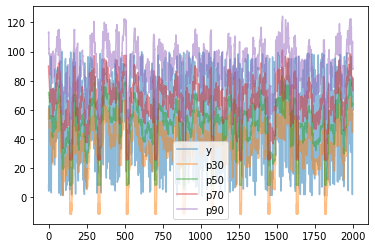

In [ ]:
plt.plot(y_true.flatten(), alpha=0.5, label='y')
for idx, p in enumerate([30, 50, 70, 90]):
    y_p = y_hat[:, :, idx]
    plt.plot(y_p.flatten(), alpha=0.5, label=f'p{p}')
    print(f'calibration p{p}: ', (y_true.flatten() <= y_p.flatten()).mean())
plt.legend()